# NetPointLib
This notebook demonstrates an example use case of the NetPointLib.
The data used is the Chicago crime data points Feb 7-27 and the Chicago Road centerline obtained using the osmnx library.

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join('../lib'))
if module_path not in sys.path:
    sys.path.append(module_path)


from map_matching import *
from hotspot import *

In [2]:
%pip install anytree

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
crimes = pd.read_csv("../data/Crimes_Chicago_last 30.csv")


In [5]:
xmin = crimes["Longitude"].min()
xmax = crimes["Longitude"].max()
ymin = crimes["Latitude"].min()
ymax = crimes["Latitude"].max()

In [6]:
prob = (xmin, ymin)

In [7]:
G = match_events_to_tile_cropped_by_place("Chicago", prob, crimes, show_log = True)

AttributeError: module 'shapely' has no attribute 'intersection'

To project the data points to the network, we specify the input city network by name and the csv file containing the data points. The x and y coordinates are the 'Longityde' colum and 'Latitude' colum. The number of cores available for CyberGIS-Jupyter is 10.

In [2]:
G = match_points_to_network("Chicago", "../data/Crimes_Chicago_last 30.csv",  "Longitude", "Latitude", 10)

348  edges removed


In [3]:
count = 0
for e in G.edges:
    print(G.edges[e])
    count += 1
    if count > 100:
        break

{'osmid': 435504207, 'oneway': False, 'lanes': '2', 'name': 'West Devon Avenue', 'highway': 'secondary', 'maxspeed': '35 mph', 'reversed': False, 'length': 51.463}
{'length': 70.218, 'oneway': False}
{'osmid': 24088469, 'name': 'North Lenox Avenue', 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 13.385}
{'osmid': 313310422, 'lanes': '4', 'ref': 'US 14', 'name': 'North Caldwell Avenue', 'highway': 'primary', 'oneway': False, 'reversed': False, 'length': 5.137}
{'osmid': 313310422, 'lanes': '4', 'ref': 'US 14', 'name': 'North Caldwell Avenue', 'highway': 'primary', 'oneway': False, 'reversed': True, 'length': 7.854}
{'osmid': 606954480, 'oneway': False, 'lanes': '2', 'ref': 'US 14', 'name': 'North Caldwell Avenue', 'highway': 'primary', 'reversed': False, 'length': 37.465}
{'length': 31.073, 'oneway': False}
{'osmid': 410133331, 'lanes': '6', 'ref': 'US 14', 'name': 'West Peterson Avenue', 'highway': 'primary', 'oneway': False, 'reversed': False, 'length': 28.48}

In [8]:
for n in G.nodes:
    if n < 0:
        print(n)
        break

-201


The fused data set is visualized below with the data points highlighted in red.

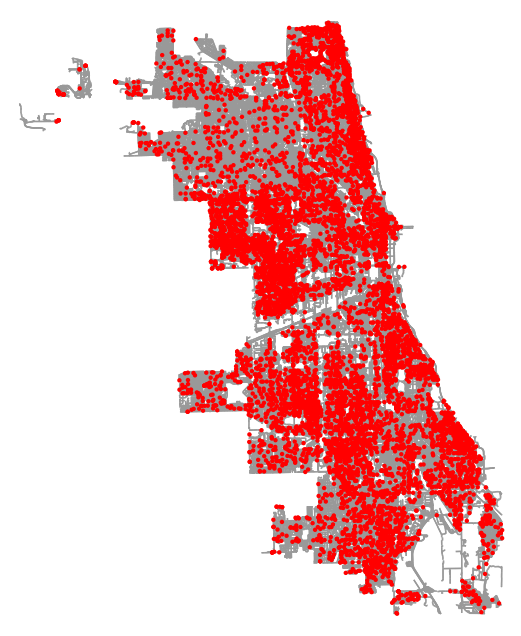

In [4]:
nc = ["r" if (node <0) else "b" for node in G.nodes()]
ns = [10 if (node <0) else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size = ns, bgcolor = '#ffffff', save = False)

With the fused data, one of the example analysis we can perform is the network local auto k function. By default it set the radius of the subnetworks to be 1600 meters.

In [ ]:
from network_local_k import *
result_dict = {}
for node in G.nodes:
    result = network_local_k(node, G, wholeN(G), wholeL(G), show_log = False)
    result_dict[node] = result

All points who are centers of the subnetworks considered clusters by the k function with the 95% confidence level is highlighted in red below

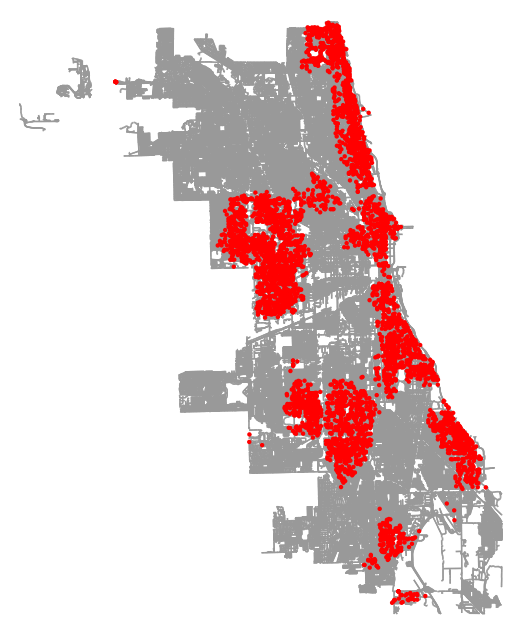

In [18]:
nc = ["r" if (node < 0 and resultDic[node] > 0) else "b" for node in G.nodes()]
ns = [10 if (node < 0 and resultDic[node] > 0) else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size = ns, bgcolor = '#ffffff', save = False)

We then highlight the parts of the network that are hotspots (clustered) and coldspots (dispersed) in red and blue respectivelly:

In [21]:
highlight_edges = set()
lowlight_edges = set()
for n in resultDic.keys():
    if resultDic[n] > 0:
        distances, paths = nx.single_source_dijkstra(G,n,cutoff=1600, weight = 'length') 
        for m in paths.keys():
            highlight_edges.update(list(G.edges(m)))
    if resultDic[n] < 0:
        distances, paths = nx.single_source_dijkstra(G,n,cutoff=1600, weight = 'length') 
        for m in paths.keys():
            lowlight_edges.update(list(G.edges(m)))

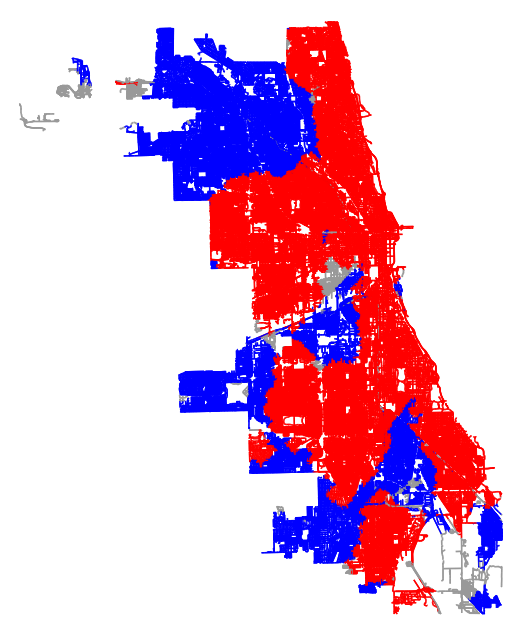

In [24]:
ec = ["r" if edge in highlight_edges else "b" if edge in lowlight_edges else "#999999" for edge in G.edges()]
fig, ax = ox.plot_graph(G, node_color='b', node_size = 0, edge_color = ec, bgcolor = '#ffffff', save = False)